In [1]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import string

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='cp437', errors='ignore'):
        yield eval(l)

In [4]:
data = []
for d in readGz("assignment1/trainRecipes.json.gz"):
    data.append(d)

In [5]:
train = data[:190000]
validation = data[190000:]

In [20]:
Y_train = []
Y_val = []
for i in train:
    Y_train.append(i["minutes"])

for i in validation:
    Y_val.append(i["minutes"])

In [21]:
print(Y_train[:5], Y_val[:5])

[10, 40, 50, 25, 55] [40, 195, 32, 3, 70]


In [43]:
train[11]

{'name': 'spiced apple pork loin roast',
 'minutes': 100,
 'contributor_id': '83301801',
 'submitted': '2003-12-03',
 'steps': 'set oven to 350f\tin a small bowl , combine the first 4 ingredients\tset aside\tcut slits in top of roast\tinsert the garlic strips\tcombine flour , salt , sugar , pepper and mustard\trub over roast\tplace the roast on a rack , in a shallow roasting pan\tbake , uncovered at 350f , or until a meat thermometer reads 160f\tbrush applesauce mixture over the roast during the last half hour of baking\tremove the roast to serving platter\tslice',
 'description': 'my family loves this pork roast! the applesauce recipe can be doubled if desired.',
 'ingredients': ['applesauce',
  'brown sugar',
  'vinegar',
  'clove',
  'boneless pork loin roast',
  'garlic cloves',
  'flour',
  'salt',
  'sugar',
  'pepper',
  'prepared mustard'],
 'recipe_id': '53080816'}

### Model that uses the sum of numbers in the steps

In [19]:
# finds sum of digits in a string, tries to filter measurements and temperatures
def findSum(str1):
 
    # A temporary str1ing
    temp = "0"
 
    # holds sum of all numbers
    # present in the str1ing
    Sum = 0
 
    # read each character in input string
    for ch in str1:
 
        # if current character is a digit
        if (ch.isdigit()):
            temp += ch
 
        # if current character is an alphabet
        else:
            # to prevent temperature from being counted, or measurements
            if ch in ['c','f','-','x']:
                temp = "0"
            # increment Sum by number found
            # earlier(if any)
            Sum += int(temp)
 
            # reset temporary str1ing to empty
            temp = "0"
 
    # atoi(temp.c_str1()) takes care
    # of trailing numbers
    return Sum + int(temp)


In [28]:
def MSE(y, ypred):
    y = np.array(y)
    ypred = np.array(ypred)
    return np.mean((y-ypred)**2)

In [24]:
# create sum of number feature
def create_sum_x(train,val):
    x_train = []
    x_val = []
    for t in train:
        num = findSum(t["steps"])
        x_train.append(num)
    
    for v in val:
        num = findSum(v["steps"])
        x_val.append(num)
    
    return x_train, x_val

In [25]:
x_train_sum, x_val_sum = create_sum_x(train,validation)


In [30]:
x_train_sum = [[x] for x in x_train_sum]
x_val_sum = [[x] for x in x_val_sum]

In [31]:
sumRidge = linear_model.Ridge(alpha=1.0)
sumRidge.fit(x_train_sum,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [32]:
y_sum_pred = sumRidge.predict(x_val_sum)
MSE(y_sum_pred,Y_val)
# MSE on the validation using the sum of all values in the steps model, not accurate lots of noise

6559.686875103911

[]

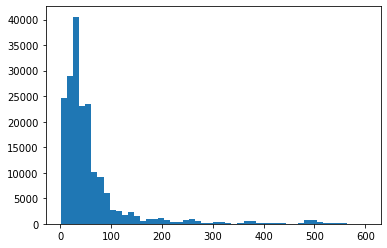

In [36]:
plt.hist(Y_train,bins=50)
plt.plot()

In [38]:
MSE([np.mean(Y_val) for i in range(len(Y_val))], Y_val)
#MSE if i guess the average everytime

6560.841219589999

### Bag of Words with ingredients

In [46]:
ingredientCount = defaultdict(int)
for t in train:
    for ing in t["ingredients"]:
        ingredientCount[ing] += 1

In [48]:
ingCountList = [(ingredientCount[w], w) for w in ingredientCount]
ingCountList.sort(reverse=True)
ingCountList[:10]

[(70355, 'salt'),
 (45391, 'butter'),
 (36380, 'sugar'),
 (32113, 'onion'),
 (28322, 'water'),
 (27869, 'eggs'),
 (27120, 'olive oil'),
 (21614, 'flour'),
 (21287, 'milk'),
 (21020, 'garlic cloves')]

In [58]:
n = 5000
topNIng = []
for i in range(n):
    topNIng.append(ingCountList[i][1])
topNIng[:10]

['salt',
 'butter',
 'sugar',
 'onion',
 'water',
 'eggs',
 'olive oil',
 'flour',
 'milk',
 'garlic cloves']

In [59]:
topNIngSet = set(topNIng)
ingIdDict = dict(zip(topNIng, range(len(topNIng))))

In [60]:
def createBagofWords(data,n):
    bag = [0]*n
    ing = data["ingredients"]
    for i in ing:
        if i in topNIngSet:
            bag[ingIdDict[i]] += 1
    return bag

In [61]:
X_train_ing =  [createBagofWords(d,n) for d in train]
X_val_ing =  [createBagofWords(d,n) for d in validation]

In [62]:
# training model
inglr = linear_model.LinearRegression()
inglr.fit(X_train_ing, Y_train)
y_validation_pred_words = inglr.predict(X_val_ing)

In [63]:
# MSE of above model
MSE(y_validation_pred_words,Y_val)

4942.422224495904

In [ ]:
#MSE is too high

### TF IDF

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
allsteps = [d["steps"] for d in train]
allsteps[0]

'heat a ridged griddle pan\tlightly brush the tomato slices and bread with some olive oil\tcook the tomato slices first , for at least 5 minutes\twhen they are almost ready , toast the bread in the same pan until well bar-marked\tin the meantime , pour a little olive oil into a small frying pan and crack in the egg\tallow it to set for a minute or so and add the garlic and chilli\tcook for a couple of minutes , spooning the hot oil over the egg until cooked to your liking\tplace the griddled bread on a plate and quickly spoon the tomatoes on top\tthrow the chives into the egg pan and splash in the balsamic vinegar\tseason well , then slide the egg on to the tomatoes and drizzle the pan juices on top\tserve immediately , with a good cup of tea !'

In [67]:
tf = TfidfVectorizer(strip_accents="ascii")
tf.fit(allsteps)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [83]:
tfTrain = tf.transform(allsteps)

In [84]:
valSteps = [d["steps"] for d in validation]
tfVal = tf.transform(valSteps)

In [85]:
# training model
tfLR = linear_model.LinearRegression()
tfLR.fit(tfTrain, Y_train)
tfPredicted = tfLR.predict(tfVal)

In [86]:
#MSE for TF IDF
MSE(tfPredicted,Y_val)

3860.781017628146

In [97]:
from sklearn.pipeline import Pipeline

In [98]:
# more efficient implementation
tfidfModel = Pipeline([
    ("tf idf", TfidfVectorizer(stop_words="english", strip_accents="ascii")),
    ("SGD", linear_model.SGDRegressor(loss="squared_loss", max_iter=4000))
])

#### Writing predictions

In [108]:
finalX = []
finalY = []
for d in readGz("assignment1/trainRecipes.json.gz"):
    temp = d["steps"] + " " + d["description"]
    finalX.append(temp)
    finalY.append(d["minutes"])

In [109]:
tfidfModel.fit(finalX,finalY)

Pipeline(memory=None,
         steps=[('tf idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents='ascii',
                                 sublinear_tf=False,
                                 token_p...
                                 vocabulary=None)),
                ('SGD',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling

In [110]:
cooktimepred = open("cooktimepred.txt", 'w')
cooktimepred.write("recipe_id,prediction\n")
for d in readGz("assignment1/testRecipes.json.gz"):
    t = d["steps"] + " " + d["description"]
    x = [t]
    pred = tfidfModel.predict(x)[0]
    cooktimepred.write(d['recipe_id'] + ',' + str(pred) + '\n')
cooktimepred.close()